# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 1

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [ ]:
def xavier_init(in_dim, out_dim):
    std = (2.0 / (in_dim + out_dim)) ** 0.5
    return torch.randn(in_dim, out_dim) * std

class Processing_Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def split(self, train_ratio=0.7, seed=GROUP_NUMBER):
        torch.manual_seed(seed)
        indices = torch.randperm(len(self.X))
        train_size = int(train_ratio * len(self.X))
        train_indices = indices[:train_size]
        test_indices = indices[train_size:]
        train_dataset = Processing_Dataset(self.X[train_indices], self.y[train_indices])
        test_dataset = Processing_Dataset(self.X[test_indices], self.y[test_indices])
        return train_dataset, test_dataset

class MLP:

    def __init__(self, input_size=2, hidden_size=16, output_size=1, seed=GROUP_NUMBER):
        torch.manual_seed(seed)
        # Use Xavier initialization and make tensors require gradients
        self.W1 = xavier_init(input_size, hidden_size).requires_grad_()
        self.b1 = torch.zeros(hidden_size, requires_grad=True)

        self.W2 = xavier_init(hidden_size, hidden_size).requires_grad_()
        self.b2 = torch.zeros(hidden_size, requires_grad=True)

        self.W3 = xavier_init(hidden_size, hidden_size).requires_grad_()
        self.b3 = torch.zeros(hidden_size, requires_grad=True)

        self.W4 = xavier_init(hidden_size, output_size).requires_grad_()
        self.b4 = torch.zeros(output_size, requires_grad=True)
    
    def forward(self, x):
        z_1 = x @ self.W1 + self.b1
        a_1 = torch.relu(z_1)

        z_2 = a_1 @ self.W2 + self.b2
        a_2 = torch.relu(z_2)

        z_3 = a_2 @ self.W3 + self.b3
        a_3 = torch.relu(z_3)

        z_4 = a_3 @ self.W4 + self.b4
        a_4 = torch.sigmoid(z_4)

        return a_4
    
    def Weights_Biases(self):
        return [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4]
    
    def reset_gradients(self):
        for param in self.Weights_Biases():
            param.grad = None

    def predict(self, x):
        with torch.no_grad():
            outputs = self.forward(x)
            predictions = (outputs >= 0.5).float()
        return predictions
    

class Training_Loop:

    def __init__(self, model=None, learning_rate=0.01, epochs=100, batch_size=128, device='cpu', l2_lambda=0.0):
        if model is None:
            self.model = MLP()
        else:
            self.model = model
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device
        self.l2_lambda = l2_lambda
        self.entire_data = { 'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': [] }

    def binary_cross_entropy(self, y_hat, y):
        epsilon = 1e-7  # To avoid log(0)
        outputs = torch.clamp(y_hat, epsilon, 1 - epsilon)
        loss = - (y * torch.log(outputs) + (1 - y) * torch.log(1 - outputs))
        mean_loss = loss.mean()
        return mean_loss

    def compute_accuracy(self, y_hat, y):
        predictions = (y_hat >= 0.5).float()
        correct = (predictions == y).float().sum()
        accuracy = correct / y.shape[0]
        return float(accuracy)

    def update_weights(self):
        with torch.no_grad():
            for param in self.model.Weights_Biases():
                if param.grad is None:
                    continue
                grad = param.grad
                # Only apply L2 to weights, not biases
                if self.l2_lambda and param.ndim > 1:
                    grad = grad + self.l2_lambda * param.data
                # in-place update of the underlying data
                param.data.add_(-self.learning_rate * grad)

        for param in self.model.Weights_Biases():
            param.grad = None

    def train_one_epoch(self, train_dataset):
        self.model.reset_gradients()
        total_loss = 0.0
        total_acc = 0.0
        n_batches = 0

        for i in range(0, len(train_dataset), self.batch_size):
            X_batch = train_dataset.X[i:i+self.batch_size].to(self.device)
            y_batch = train_dataset.y[i:i+self.batch_size].to(self.device)

            outputs = self.model.forward(X_batch)

            loss = self.binary_cross_entropy(outputs, y_batch)

            loss.backward()

            total_loss += float(loss.detach().cpu().item())
            total_acc += self.compute_accuracy(outputs, y_batch)

            # update parameters safely
            self.update_weights()

            n_batches += 1
        
        if n_batches == 0:
            return float('nan'), float('nan')
        avg_loss = total_loss / n_batches
        avg_acc = total_acc / n_batches

        return avg_loss, avg_acc
    
    def evaluate(self, test_dataset):
        with torch.no_grad():
            X_test = test_dataset.X.to(self.device)
            y_test = test_dataset.y.to(self.device)

            outputs = self.model.forward(X_test)
            loss = self.binary_cross_entropy(outputs, y_test)
            accuracy = self.compute_accuracy(outputs, y_test)

        return float(loss.item()), float(accuracy)
    
    def train(self, train_dataset, test_dataset):
        for epoch in range(self.epochs):
            train_loss, train_acc = self.train_one_epoch(train_dataset)
            test_loss, test_acc = self.evaluate(test_dataset)

            self.entire_data['train_loss'].append(train_loss)
            self.entire_data['test_loss'].append(test_loss)
            self.entire_data['train_accuracy'].append(train_acc)
            self.entire_data['test_accuracy'].append(test_acc)

            if (epoch+1) % 10 == 0 or epoch == 0:
                print(f"Epoch [{epoch+1}/{self.epochs}] - Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.4f} - Test Loss: {test_loss:.6f}, Test Acc: {test_acc:.4f}")

        return self.entire_data

class Visualization:
    @staticmethod
    def plot_loss_acc(entire_data):
        epochs = range(1, len(entire_data['train_loss']) + 1)
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, entire_data['train_loss'], label='Train Loss', color='blue')
        plt.plot(epochs, entire_data['test_loss'], label='Test Loss', color='red')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss over Epochs')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, entire_data['train_accuracy'], label='Train Accuracy', color='blue')
        plt.plot(epochs, entire_data['test_accuracy'], label='Test Accuracy', color='red')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy over Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_decision_boundary(self, model: MLP, X_val: torch.Tensor, y_val: torch.Tensor, res=300):
        x_min, x_max = X_val[:,0].min().item() - 0.5, X_val[:,0].max().item() + 0.5
        y_min, y_max = X_val[:,1].min().item() - 0.5, X_val[:,1].max().item() + 0.5
        xs = torch.linspace(x_min, x_max, res)
        ys = torch.linspace(y_min, y_max, res)
        xx, yy = torch.meshgrid(xs, ys, indexing='xy')
        grid = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1)
        with torch.no_grad():
            probs = model.forward(grid).reshape(res, res).numpy()
        plt.figure(figsize=(6,6))
        cs = plt.contour(xx.numpy(), yy.numpy(), probs, levels=[0.5], linewidths=2, colors='k')
        plt.contourf(xx.numpy(), yy.numpy(), probs, levels=50, alpha=0.6)
        y_arr = y_val.flatten().numpy()
        X_arr = X_val.numpy()
        plt.scatter(X_arr[:,0], X_arr[:,1], c=y_arr, cmap='coolwarm', edgecolors='k', s=20)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Geospatial Threat Map (Decision Boundary at prob=0.5)')
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.show()

    


Epoch [1/400] - Train Loss: 0.707660, Train Acc: 0.4993 - Test Loss: 0.699203, Test Acc: 0.4833
Epoch [10/400] - Train Loss: 0.657673, Train Acc: 0.5836 - Test Loss: 0.648788, Test Acc: 0.6122
Epoch [20/400] - Train Loss: 0.649099, Train Acc: 0.5836 - Test Loss: 0.639982, Test Acc: 0.6122
Epoch [30/400] - Train Loss: 0.643302, Train Acc: 0.5712 - Test Loss: 0.634463, Test Acc: 0.5911
Epoch [40/400] - Train Loss: 0.637586, Train Acc: 0.5478 - Test Loss: 0.629191, Test Acc: 0.5667
Epoch [50/400] - Train Loss: 0.631719, Train Acc: 0.5318 - Test Loss: 0.623881, Test Acc: 0.5411
Epoch [60/400] - Train Loss: 0.625398, Train Acc: 0.5373 - Test Loss: 0.617900, Test Acc: 0.5556
Epoch [70/400] - Train Loss: 0.613131, Train Acc: 0.5683 - Test Loss: 0.606215, Test Acc: 0.5833
Epoch [80/400] - Train Loss: 0.601833, Train Acc: 0.6027 - Test Loss: 0.595867, Test Acc: 0.6356
Epoch [90/400] - Train Loss: 0.590318, Train Acc: 0.6337 - Test Loss: 0.584744, Test Acc: 0.6556
Epoch [100/400] - Train Loss: 0

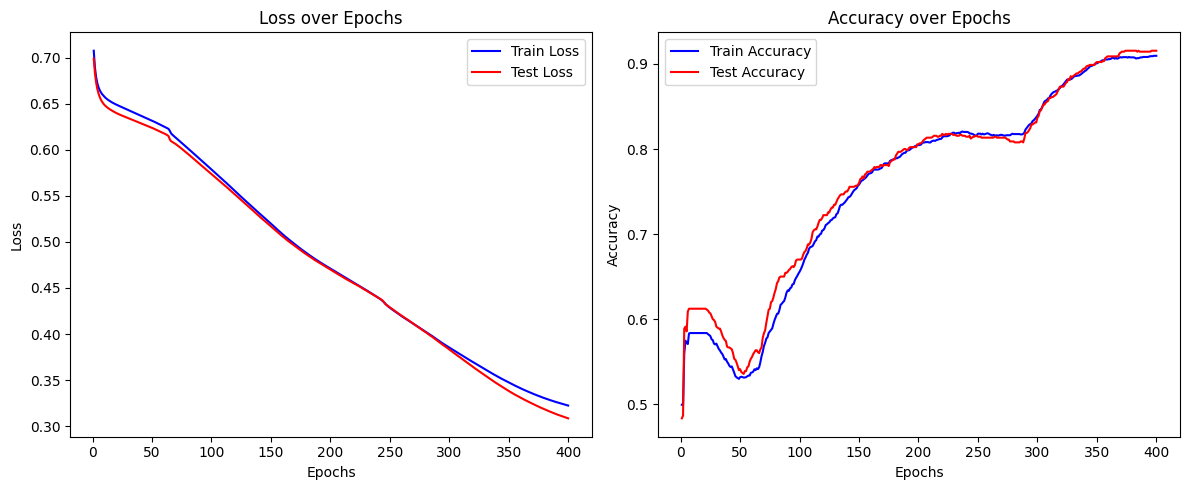

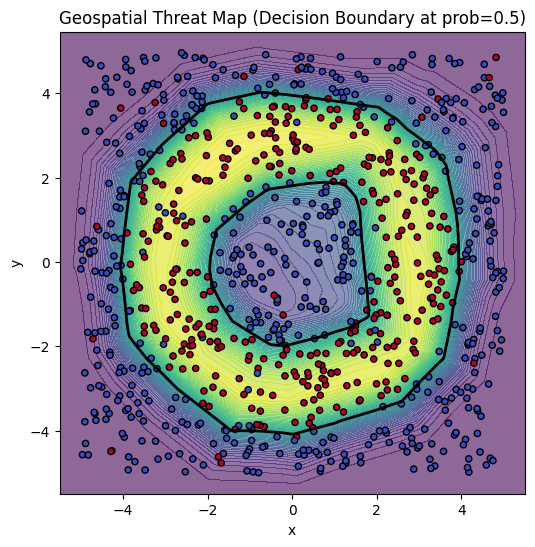

Final Results:
Train Loss: 0.322307, Train Accuracy: 0.9096
Test Loss: 0.308427, Test Accuracy: 0.9156


In [32]:

if __name__ == "__main__":
    model = MLP(input_size=2, hidden_size=16, output_size=1, seed=GROUP_NUMBER)
    dataset = Processing_Dataset(X_full, y_full)
    train_dataset, test_dataset = dataset.split(train_ratio=0.7, seed=GROUP_NUMBER)

    trainer = Training_Loop(model=model, learning_rate=0.01, epochs=400, batch_size=128, device='cpu', l2_lambda=0.0001)
    entire_data = trainer.train(train_dataset, test_dataset)

    viz = Visualization()
    viz.plot_loss_acc(entire_data)
    viz.plot_decision_boundary(model, test_dataset.X, test_dataset.y)

    print("Final Results:")
    print(f"Train Loss: {entire_data['train_loss'][-1]:.6f}, Train Accuracy: {entire_data['train_accuracy'][-1]:.4f}")
    print(f"Test Loss: {entire_data['test_loss'][-1]:.6f}, Test Accuracy: {entire_data['test_accuracy'][-1]:.4f}")

    